In [2]:
import numpy as np
import pandas as pd
import os
!pip install yahooquery
import yahooquery
from pandas_datareader import data
!pip install nltk==3.3
from datetime import timedelta, date, datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


     |████████████████████████████████| 51kB 2.7MB/s 
     |████████████████████████████████| 5.5MB 6.1MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp37-none-any.whl size=7012 sha256=5c80256f4eda42e32487276e72e40764b308520947790b5fcc08d18d9f98f785
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
     |████████████████████████████████| 1.4MB 4.3MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp37-none-any.whl size=1394471 sha256=4839a1b86d6f68800e7d9fc5a330524f8adbb7d8630fa40cd7624eea649acfb7
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca8

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Get historical stock data

In [4]:
def get_yahoo_dataframe(symbol):
  # Get historical data
  #symbol = 'AAPL'
  ticker = yahooquery.Ticker(symbol)
  df = pd.DataFrame(ticker.history(start='2020-06-01', end='2021-01-29'))
  df=data.DataReader(symbol, 'yahoo', '20200601', '20210129').reset_index()
  df = df[['Date','Adj Close', 'Volume']]
  (df[:10].style.format(dict(Date='{:%d/%m/%Y}'))
  .background_gradient(subset='Volume',cmap='Blues')
  .background_gradient(subset='Adj Close',cmap='Blues')
  )
  df.Volume.plot()
  df["Adj Close"].plot()
  dates = pd.DataFrame(pd.date_range('20200601',periods=8*31))
  df.set_index(pd.to_datetime(df['Date']), inplace=True)
  df = df.drop(['Date'], axis=1)
  return df

,Adj Close,Volume
Date,,
2020-06-01,80.059723,80791200.0
2020-06-02,80.430351,87642800.0
2020-06-03,80.873131,104491200.0
2020-06-04,80.176636,87560400.0
2020-06-05,82.460152,137250400.0
...,...,...
2021-01-25,142.706757,157611700.0
2021-01-26,142.946396,98390600.0
2021-01-27,141.848038,140843800.0


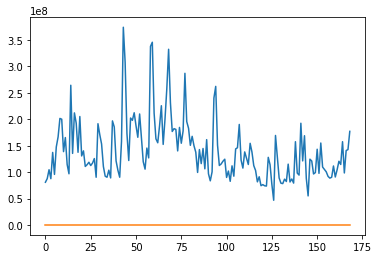

In [5]:
symbol='AAPL'
df = get_yahoo_dataframe(symbol)
df

In [6]:
def process_stock_data(filename, df):
  stock_file = pd.read_csv(filename)
  stock_file.set_index(pd.to_datetime(stock_file['Date']), inplace=True)
  stock_file.drop('Date', axis=1)
  stock_file = stock_file.reindex(df.index, method='bfill')
  #stock_file = stock_file.drop('Date', axis=1)
  #stock_file = stock_file.drop('Period Ending', axis=1)
  return stock_file

In [7]:
# Optional, just because Ish is using Colab
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [8]:
stock_file=process_stock_data('/content/gdrive/My Drive/Colab Notebooks/earnings_data/AAPL.csv', df)
print(stock_file)

                  Date Period Ending  ...  Estimated_Revenue  Reported_Revenue
Date                                  ...                                     
2020-06-01  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-02  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-03  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-04  2020-04-30    2020-03-01  ...           53668.84           58313.0
2020-06-05  2020-04-30    2020-03-01  ...           53668.84           58313.0
...                ...           ...  ...                ...               ...
2021-01-25  2020-10-29    2020-09-01  ...           63388.91           64698.0
2021-01-26  2020-10-29    2020-09-01  ...           63388.91           64698.0
2021-01-27  2021-01-27    2020-12-01  ...          102512.80          111439.0
2021-01-28  2021-01-27    2020-12-01  ...          102512.80          111439.0
2021-01-29  2021-01-27    2020-12-01  ...          1

In [9]:
df = df.join(stock_file)

In [10]:
df

,Adj Close,Volume,Date,Period Ending,Estimated_EPS,Reported_EPS,Surprise_EPS,Estimated_Revenue,Reported_Revenue
Date,,,,,,,,,
2020-06-01,80.059723,80791200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0
2020-06-02,80.430351,87642800.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0
2020-06-03,80.873131,104491200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0
2020-06-04,80.176636,87560400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0
2020-06-05,82.460152,137250400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0
...,...,...,...,...,...,...,...,...,...
2021-01-25,142.706757,157611700.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0
2021-01-26,142.946396,98390600.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0
2021-01-27,141.848038,140843800.0,2021-01-27,2020-12-01,1.41,1.68,0.27,102512.80,111439.0


# Get news sentiment

In [11]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def get_yahoo_news(symbol):
  start_date = date(2020, 6, 1)
  end_date = date(2021, 1, 29)
  data = []
  run_Dict = []
  ticker = yahooquery.Ticker(symbol)
  for single_date in daterange(start_date, end_date):
      daily_news = ticker.news(start=single_date.strftime("%Y-%m-%d"))
      for article in daily_news:
          #print(article)
          title = article['title']
          if title in run_Dict:
              continue
          else:
              try:
                  run_Dict.append(title)
                  publisher_time = article['provider_publish_time']
                  publisher_time = datetime.utcfromtimestamp(int(publisher_time)).strftime('%Y-%m-%d')
                  data.append([publisher_time, title, article['summary']])
              except KeyError:
                  print("KeyError generated.")
                  continue
          if len(run_Dict) > 30:
              run_Dict = run_Dict[-30:]
  print(len(data))
  news = pd.DataFrame(data, columns=["date", "Title", "Summary"])
  nltk.download("vader_lexicon")
  sentimentAnalyser = SentimentIntensityAnalyzer()
  news["compound"] = [sentimentAnalyser.polarity_scores(v)['compound'] for v in news["Summary"]]
  news["negative"] = [sentimentAnalyser.polarity_scores(v)['neg'] for v in news["Summary"]]
  news["positive"] = [sentimentAnalyser.polarity_scores(v)['pos'] for v in news["Summary"]]
  news["neutral"] = [sentimentAnalyser.polarity_scores(v)['neu'] for v in news["Summary"]]
  news = news.sort_values(by="date")
  return news

In [12]:
news=get_yahoo_news(symbol)
print(news)

973
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
           date  ... neutral
24   2020-05-08  ...   0.925
23   2020-05-08  ...   1.000
22   2020-05-08  ...   1.000
21   2020-05-11  ...   0.868
20   2020-05-11  ...   0.771
..          ...  ...     ...
950  2021-01-28  ...   1.000
949  2021-01-28  ...   0.840
899  2021-01-28  ...   0.755
830  2021-01-29  ...   1.000
829  2021-02-12  ...   0.700

[973 rows x 7 columns]


In [13]:
def get_sentiment_from_news(news):
  news_sentiment = news[['date', 'compound']]
  print(news_sentiment)
  news_sentiment.set_index(pd.to_datetime(news_sentiment['date']), inplace=True)
  print(news_sentiment[:10])
  news_sentiment = news_sentiment['compound']
  total_sentiment = news_sentiment.groupby('date').agg(lambda x: sum(x))
  total_sentiment = total_sentiment.rename('Total Sentiment')
  nArticles = news_sentiment.groupby('date').count()
  avg_sentiment = total_sentiment/nArticles
  avg_sentiment = avg_sentiment.rename('Avg Sentiment')
  sentiment_data = pd.concat([total_sentiment, avg_sentiment], axis=1)
  sentiment_data = sentiment_data.reindex(df.index, method='ffill')
  return sentiment_data

In [14]:
sentiment_data=get_sentiment_from_news(news)
print(sentiment_data)

           date  compound
24   2020-05-08   -0.4902
23   2020-05-08    0.0000
22   2020-05-08    0.0000
21   2020-05-11    0.4939
20   2020-05-11    0.8176
..          ...       ...
950  2021-01-28    0.0000
949  2021-01-28    0.2732
899  2021-01-28    0.6369
830  2021-01-29    0.0000
829  2021-02-12    0.8934

[973 rows x 2 columns]
                  date  compound
date                            
2020-05-08  2020-05-08   -0.4902
2020-05-08  2020-05-08    0.0000
2020-05-08  2020-05-08    0.0000
2020-05-11  2020-05-11    0.4939
2020-05-11  2020-05-11    0.8176
2020-05-11  2020-05-11    0.0000
2020-05-12  2020-05-12    0.0000
2020-05-12  2020-05-12    0.1531
2020-05-12  2020-05-12    0.0000
2020-05-12  2020-05-12   -0.4588
            Total Sentiment  Avg Sentiment
Date                                      
2020-06-01          -1.2498      -0.312450
2020-06-02          -1.6542      -0.827100
2020-06-03          -1.6542      -0.827100
2020-06-04          -1.7959      -0.256557
2020-06-05

In [15]:
df = df.join(sentiment_data)

In [16]:
df

,Adj Close,Volume,Date,Period Ending,Estimated_EPS,Reported_EPS,Surprise_EPS,Estimated_Revenue,Reported_Revenue,Total Sentiment,Avg Sentiment
Date,,,,,,,,,,,
2020-06-01,80.059723,80791200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.2498,-0.312450
2020-06-02,80.430351,87642800.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100
2020-06-03,80.873131,104491200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100
2020-06-04,80.176636,87560400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557
2020-06-05,82.460152,137250400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,142.706757,157611700.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0,6.3311,0.263796
2021-01-26,142.946396,98390600.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0,9.4487,0.363412
2021-01-27,141.848038,140843800.0,2021-01-27,2020-12-01,1.41,1.68,0.27,102512.80,111439.0,3.4509,0.156859


In [17]:
# df = df.drop('Estimated_Revenue', axis=1)
# df = df.drop('Reported_Revenue', axis=1)
# df = df.drop('Date', axis=1)
# df = df.drop('Estimated_EPS', axis=1)
# # df = df.drop('Reported_EPS', axis=1)
# df = df.drop('Period Ending', axis=1)

In [18]:
df[:10]

,Adj Close,Volume,Date,Period Ending,Estimated_EPS,Reported_EPS,Surprise_EPS,Estimated_Revenue,Reported_Revenue,Total Sentiment,Avg Sentiment
Date,,,,,,,,,,,
2020-06-01,80.059723,80791200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.2498,-0.312450
2020-06-02,80.430351,87642800.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100
2020-06-03,80.873131,104491200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100
2020-06-04,80.176636,87560400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557
2020-06-05,82.460152,137250400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557
2020-06-08,82.947685,95654400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,0.6364,0.318200
2020-06-09,85.567009,147712400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,0.6364,0.318200
2020-06-10,87.768440,166651600.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,0.0000,0.000000
2020-06-11,83.554642,201662400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,1.5012,0.750600


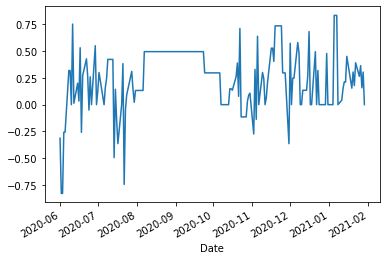

In [19]:
df['Avg Sentiment'].plot()

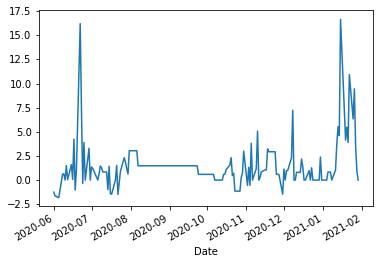

In [20]:
df['Total Sentiment'].plot()

In [21]:
df['Weekly Sentiment'] = df['Avg Sentiment'].rolling(5, win_type='triang').sum()

In [22]:
df['Monthly Sentiment'] = df['Avg Sentiment'].rolling(20, win_type='triang').sum()

In [23]:
df

,Adj Close,Volume,Date,Period Ending,Estimated_EPS,Reported_EPS,Surprise_EPS,Estimated_Revenue,Reported_Revenue,Total Sentiment,Avg Sentiment,Weekly Sentiment,Monthly Sentiment
Date,,,,,,,,,,,,,
2020-06-01,80.059723,80791200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.2498,-0.312450,NaN,NaN
2020-06-02,80.430351,87642800.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100,NaN,NaN
2020-06-03,80.873131,104491200.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.6542,-0.827100,NaN,NaN
2020-06-04,80.176636,87560400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557,NaN,NaN
2020-06-05,82.460152,137250400.0,2020-04-30,2020-03-01,0.52,0.64,0.12,53668.84,58313.0,-1.7959,-0.256557,-1.739207,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,142.706757,157611700.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0,6.3311,0.263796,0.779491,3.038905
2021-01-26,142.946396,98390600.0,2020-10-29,2020-09-01,0.69,0.73,0.04,63388.91,64698.0,9.4487,0.363412,0.906920,2.990882
2021-01-27,141.848038,140843800.0,2021-01-27,2020-12-01,1.41,1.68,0.27,102512.80,111439.0,3.4509,0.156859,0.877631,2.949861


# Output prep

In [24]:
def prepare_data_Y_for_ML(df):
  output = df['Adj Close']
  output.rename('Stock Price')
  advance = df['Adj Close'].shift(10)
  advance = advance.rename('Short Term Advance')
  advance2 = df['Adj Close'].shift(40)
  advance2 = advance2.rename('Mid Term Advance')
  gt = pd.concat([output, advance, advance2], axis=1)
  gt['Short Term Change'] = ((gt['Short Term Advance'] - gt['Adj Close'])/gt['Adj Close'])*100
  gt['Mid Term Change'] = ((gt['Mid Term Advance'] - gt['Adj Close'])/gt['Adj Close'])*100
  #print(gt[9:110])
  gt['Short Term Change'].plot()

  Y = gt['Short Term Change'][10:]
  return Y

In [43]:
def prepare_data_X_for_ML(df):
  avg_monthly_sentiment = df['Monthly Sentiment'].sum()/len(df['Monthly Sentiment'])
  avg_week = df['Weekly Sentiment'].sum()/len(df['Monthly Sentiment'])
  X = df[10:]
  X['Monthly Sentiment'] =  X['Monthly Sentiment'].fillna(avg_monthly_sentiment)
  X['Weekly Sentiment'] = X['Weekly Sentiment'].fillna(avg_week)
  X=X.drop(['Date','Estimated_Revenue','Reported_Revenue','Estimated_EPS','Reported_EPS','Period Ending'],axis=1)
  return X

Date
2020-06-15   -6.163437
2020-06-16   -8.162925
2020-06-17   -7.528655
2020-06-18   -8.361529
2020-06-19   -5.209879
                ...   
2021-01-25   -7.605660
2021-01-26   -9.905002
2021-01-27   -9.334087
2021-01-28   -4.522577
2021-01-29   -2.311300
Name: Short Term Change, Length: 159, dtype: float64


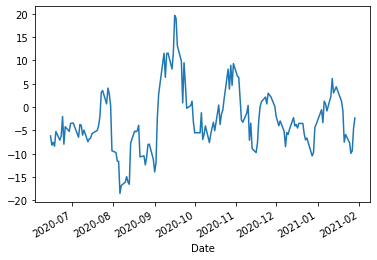

In [26]:
Y=prepare_data_Y_for_ML(df)
print(Y)

In [45]:
X=prepare_data_X_for_ML(df)
print(X)

             Adj Close       Volume  ...  Weekly Sentiment  Monthly Sentiment
Date                                 ...                                     
2020-06-15   85.318260  138808800.0  ...          0.932000           2.326875
2020-06-16   87.579391  165428800.0  ...          0.658083           2.326875
2020-06-17   87.457504  114406400.0  ...          0.658225           2.326875
2020-06-18   87.492332   96820400.0  ...          0.438883           2.326875
2020-06-19   86.992348  264476000.0  ...          0.537492           2.326875
...                ...          ...  ...               ...                ...
2021-01-25  142.706757  157611700.0  ...          0.779491           3.038905
2021-01-26  142.946396   98390600.0  ...          0.906920           2.990882
2021-01-27  141.848038  140843800.0  ...          0.877631           2.949861
2021-01-28  136.885452  142621100.0  ...          0.875078           2.895739
2021-01-29  131.763107  177180600.0  ...          0.689310      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [29]:
Y

Date
2020-06-15   -6.163437
2020-06-16   -8.162925
2020-06-17   -7.528655
2020-06-18   -8.361529
2020-06-19   -5.209879
                ...   
2021-01-25   -7.605660
2021-01-26   -9.905002
2021-01-27   -9.334087
2021-01-28   -4.522577
2021-01-29   -2.311300
Name: Short Term Change, Length: 159, dtype: float64

# Test MLP regression

In [47]:
def apply_MLP(X_train,X_test,y_train,y_test):
  sc_X = StandardScaler()
  X_trainscaled=sc_X.fit_transform(X_train)
  X_testscaled=sc_X.transform(X_test)
  reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)
  y_pred=reg.predict(X_testscaled)
  print("The Score with ", (r2_score(y_pred, y_test)))
  y_pred = pd.DataFrame(y_pred)
  out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)
  out = out.rename(columns={0:"Prediction", "Short Term Change":"Ground Truth"})
  return out

In [49]:
X_train

,Adj Close,Volume,Surprise_EPS,Total Sentiment,Avg Sentiment,Weekly Sentiment,Monthly Sentiment
Date,,,,,,,
2020-11-17,119.211861,74271000.0,0.04,1.0534,0.526700,0.780350,1.146012
2020-09-29,113.723564,99382200.0,0.14,0.5920,0.296000,0.953967,4.780680
2020-10-30,108.510361,190272600.0,0.04,3.0003,0.107154,0.012638,1.392944
2020-07-23,92.380234,197004400.0,0.12,-0.2934,-0.048900,-0.250983,1.318872
2021-01-28,136.885452,142621100.0,0.27,0.9101,0.303367,0.875078,2.895739
...,...,...,...,...,...,...,...
2020-06-26,87.964951,205256800.0,0.12,0.0000,0.000000,0.438216,1.387698
2020-11-09,116.146439,154515300.0,0.04,1.1988,0.299700,0.755667,0.992791
2020-09-18,106.496849,287104900.0,0.14,1.4817,0.493900,1.481700,4.939000


In [50]:
out=apply_MLP(X_train,X_test,y_train,y_test)
print(out)

The Score with  0.6136906399276785
    Ground Truth  Prediction
0      -2.005224   -8.095993
1     -14.894008  -15.729660
2       8.983815   -5.832609
3      -5.274090   -1.805821
4      -2.777241   -6.889426
5      -3.993822   -2.226851
6      11.556013    9.244243
7      -3.481762   -1.574448
8      -9.347364   -8.976574
9      -7.588432   -9.213965
10     -4.035025    0.840507
11     -7.009782   -3.162925
12      6.397034    7.450999
13     -4.754521    0.840507
14     11.616072   11.381368
15    -18.487307  -14.327634
16     -5.118393   -4.868260
17      1.287516    7.756423
18     -4.439313   -7.296600
19     -1.984112   -6.004031
20     11.483387    9.862108
21    -11.184517  -11.519304
22     -3.247453   -1.666473
23     -0.825437    3.482950
24      8.189584   15.158538
25     -7.932245   -6.076899
26     -4.976737   -6.632079
27    -11.942541  -12.276138
28     -2.998050    0.840507
29      3.731275    0.840507
30     -7.404884   -1.882059
31     -1.531621    2.154081
32      

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


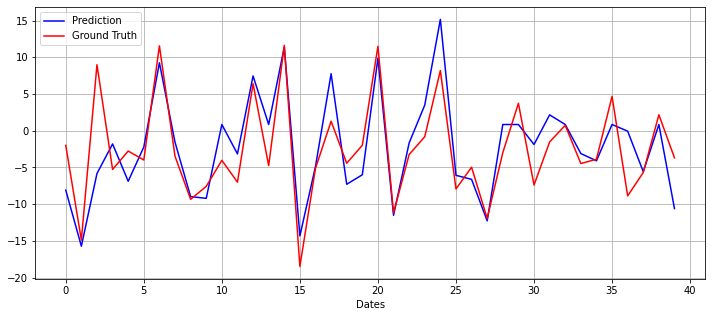

In [51]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')

ax1 = out["Prediction"].plot(color='blue', grid=True)
ax2 = out["Ground Truth"].plot(color='red', grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()


# Test SVM

In [ ]:
# One hot encoding
Y.plot()
for i,yi in enumerate(Y):
  if yi<-2:
    Y[i] =0
  elif yi<2:
    Y[i]=1
  else:
    Y[i]=2


#Y[0]=1
print(Y)

#print(Y)

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, Y_train)
clf.predict(X_test)

In [ ]:
X = df[40:]
X['Monthly Sentiment'] =  X['Monthly Sentiment'].fillna(avg_monthly_sentiment)
X['Weekly Sentiment'] = X['Weekly Sentiment'].fillna(avg_week)

In [ ]:
Y = gt['Mid Term Change'][40:]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [ ]:
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [ ]:
reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)

In [ ]:
y_pred=reg.predict(X_testscaled)
print("The Score with ", (r2_score(y_pred, y_test)))

In [ ]:
y_pred = pd.DataFrame(y_pred)
out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)

In [ ]:
out = out.rename(columns={0:"Prediction", "Mid Term Change":"Ground Truth"})

In [ ]:
out

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')

ax1 = out["Prediction"].plot(color='blue', grid=True)
ax2 = out["Ground Truth"].plot(color='red', grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()
